# **Подготовка**

## Установка

In [ ]:
!sudo apt install unar # Установим разархиватор

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unar is already the newest version (1.10.1-2build7).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # Подключим google disk

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Разархивируем образ с указаным нашим путём.
!unar 'drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataSet/CatsDogs.rar' -o 'drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataSet' -q
print("Done unarchiving")

  CatsDogs/cats/cat.1.jpg  (16880 B)... Skipping existing file.
Extraction to directory "drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataSet" failed (1 file failed.)
Done unarchiving


In [ ]:
import tensorflow as tf
from pathlib import Path
from datetime import datetime   # Библиотека для подписывания времени
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split    # Для разбития датасета.
import pandas as pd   # Импорт пандас
from tqdm import tqdm   # Для полоски статус бар.
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from shutil import rmtree

tqdm.pandas()   # Подключение статус бар для работы с пандас


device_name = tf.test.gpu_device_name()   # Проверка на наличие видеокарты
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#   Зададим константы
IMAGE_SIZE = (224,224,3)    # Размер рабочего изображения(высота и нирина) и количество каналов
MODELS_DIR = Path('drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification')   # Путь для сохранения моделей
MODELS_DIR.mkdir(parents=True, exist_ok=True)   #Создадим папку по заданному пути, если её нет.
DATASET_DIR = Path('drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataSet/CatsDogs')   # Путь для датасета
FULLSET_DIR = DATASET_DIR.joinpath('full_set')    # Весь датасет который будет храниться, нужно создать вручную
                                                  # папку full_set и положить в неё, всё что есть в датасете
                                                  # (все картинки обьединяем в одну папку).

In [ ]:
# Создадим датафрейм куда будем писать результаты экспериментов

df_results = pd.DataFrame(columns=['Model_name', 'Loss', 'Accuracy', 'time_one_jpg'])

## Подготовка данных

1 Способ.
Разбиение через image_dataset_from_directory. Нет гибкости

In [ ]:
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
# данная функция по умолчанию считает из корневой directory=DATASET_DIR все файлы
# и сведёт их по label - лам в соответствии каталогам.
# Автоматически разбивает на тренировочную и валидационную выборку,
# подготавливает изображения,


train_dataset, val_dataset = image_dataset_from_directory(
    directory=FULLSET_DIR,    # путь датасета
    image_size=IMAGE_SIZE[:2],    # размер изображения (высота и ширина)
    batch_size=32,    # Размер батча(пачка из n-го количества изображений, что-бы сразу подавать в модель n изображений)
    validation_split=0.3,   # Сколько % от выборки направим на валидацию
    subset='both',    #
    seed=43,    # фиксированное число random

)

#/content/drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataSet/CatsDogs/full_set

Found 4000 files belonging to 2 classes.
Using 2800 files for training.
Using 1200 files for validation.


In [ ]:
# Посмотрим что из себя представляет датасет
for pic, label in train_dataset:
  print(pic)      # тензор картинок
  print(label)    # тезор меток
  print
  print(pic.shape)      # размерность
  print(label.shape)    # размерность
  break

tf.Tensor(
[[[[1.26179688e+02 1.42179688e+02 1.58179688e+02]
   [2.05837051e+02 2.21837051e+02 2.33822540e+02]
   [1.25108261e+02 1.41108261e+02 1.57108261e+02]
   ...
   [2.38678711e+02 2.27678711e+02 1.99678711e+02]
   [2.36383972e+02 2.25383972e+02 1.97383972e+02]
   [2.38750000e+02 2.23750000e+02 1.94750000e+02]]

  [[1.29531250e+02 1.45531250e+02 1.61531250e+02]
   [2.11853790e+02 2.27853790e+02 2.42758926e+02]
   [1.29732147e+02 1.45732147e+02 1.61732147e+02]
   ...
   [2.40928711e+02 2.29928711e+02 2.01928711e+02]
   [2.38269012e+02 2.27269012e+02 1.99269012e+02]
   [2.38000000e+02 2.23000000e+02 1.93256729e+02]]

  [[1.25011154e+02 1.41011169e+02 1.57011169e+02]
   [2.05666290e+02 2.21666290e+02 2.37666290e+02]
   [1.31165176e+02 1.47165176e+02 1.63165176e+02]
   ...
   [2.39928711e+02 2.28928711e+02 2.00928711e+02]
   [2.37633972e+02 2.26633972e+02 1.97660767e+02]
   [2.39500000e+02 2.24623871e+02 1.92132843e+02]]

  ...

  [[1.57621658e+02 1.49621658e+02 1.26621651e+02]
   [1

2 Способ.

Формирование датасета через разбиение на отдельные папки train, val, test датасет и потом подгрузка через image_dataset_from_directory

In [ ]:
files = [(file, file.parent.name) for file in FULLSET_DIR.glob('**/*.jpg')]
df_dataset = pd.DataFrame(data=files,
                          columns=['File', 'Label'])
df_dataset['Label_i'] = df_dataset['Label'].astype('category').cat.codes


# Разобьём df_dataset на тренировочную (train) и промежуточную валидационную (valid) выборки.
train, valid = train_test_split(df_dataset, test_size=0.3, stratify=df_dataset['Label_i'], random_state=89)
print(f"{train.shape=}, {valid.shape=}")



train.shape=(2800, 3), valid.shape=(1200, 3)


In [ ]:
# Разобьём valid на валидационную (val) и тестовую (test) выборки.
val, test = train_test_split(valid, test_size=0.3, stratify=valid['Label_i'], random_state=89)
print(f"{val.shape=}, {test.shape=}")

val.shape=(840, 3), test.shape=(360, 3)


In [ ]:
df_dataset.head()

File Label  Label_i
0  drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataS...  dogs        1
1  drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataS...  dogs        1
2  drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataS...  dogs        1
3  drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataS...  dogs        1
4  drive/MyDrive/Colab Notebooks/CV/CV_HW_1/DataS...  dogs        1

In [ ]:
df_dataset.groupby('Label')['Label_i'].first()    # Сгруппируем и посмотрим.

Label
cats    0
dogs    1
Name: Label_i, dtype: int8

In [ ]:
def copy_files(x:pd.Series, dir_to_copy:Path):
    new_file_path = dir_to_copy.joinpath(x['File'].relative_to(FULLSET_DIR))
    new_file_path.parent.mkdir(exist_ok=True)
    new_file_path.write_bytes(x['File'].read_bytes())


# making dirs
train_dir = DATASET_DIR.joinpath('train_set')
rmtree(train_dir, ignore_errors=True)
train_dir.mkdir(parents=True, exist_ok=True)

val_dir = DATASET_DIR.joinpath('val_set')
rmtree(val_dir, ignore_errors=True)
val_dir.mkdir(parents=True, exist_ok=True)

test_dir = DATASET_DIR.joinpath('test_set')
rmtree(test_dir, ignore_errors=True)
test_dir.mkdir(parents=True, exist_ok=True)


#copying symlinks

for copy_dir, df in [(train_dir, train), (val_dir, val), (test_dir, test)]:
    df.progress_apply(copy_files, dir_to_copy = copy_dir, axis=1)



100%|██████████| 360/360 [00:02<00:00, 157.44it/s]


In [ ]:
train_dataset = image_dataset_from_directory(
    directory=DATASET_DIR.joinpath("train_set"),
    image_size=IMAGE_SIZE[:2],
    batch_size=32,
)

validation_dataset = image_dataset_from_directory(
    directory=DATASET_DIR.joinpath("val_set"),
    image_size=IMAGE_SIZE[:2],
    batch_size=32,

)

test_dataset = image_dataset_from_directory(
    directory=DATASET_DIR.joinpath("test_set"),
    image_size=IMAGE_SIZE[:2],
    batch_size=32,

)

Found 2800 files belonging to 2 classes.
Found 840 files belonging to 2 classes.
Found 360 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape", data_batch.shape)
    print("data batch shape", data_batch.shape)
    break

data batch shape (32, 224, 224, 3)
data batch shape (32, 224, 224, 3)


## Подготовка тестового одного изображения.

In [ ]:
# Первый вариант загрузки и подготовки одного изображения
from tensorflow.keras.preprocessing import image
import numpy as np
img_path = (str(FULLSET_DIR)+('/cats/cat.1.jpg'))         # Определяем путь до изображения (тип str)
img = image.load_img(img_path, target_size=(224, 224))          # Загружаем тестовое изображение
img_tensor = image.img_to_array(img)                            # Преобразуем изображение в массив. Массив имеет размерность ширина, высота, каналы,
                                                          # где каналы -это количество цветовых каналов изображения (RGB-3, grayscale -1).
img_tensor = np.expand_dims(img_tensor, axis=0)           # добавляем новую ос в массив NumPy в указанное место. Функция принимает 2 параметра - массив(входные данные)
                                                          # и номер позиции, в которую необходимо добавить новую ось. Новая ось будет иметь размерность 1.
                                                          # например был (100, 100, 3) а стал (1, 100, 100, 3). Т.е. преобразуем к формату, которого ждёт модель.
                                                          # Хоть рисунок и один, но должен как список рисунков.
# В нашем случае нормализацию делать не будем, так как это уже есть в нашей модели!!!
#img_tensor /= 255.                                        # Изображение нужно приводить к диапазону [0,1]
print(img_tensor.shape)                                   # Посмотрим размерность полученного значения массива изображения.


(1, 224, 224, 3)


In [ ]:
# Второй вариант загрузки и подготовки одного изображения
from keras.utils import load_img, img_to_array

import numpy as np
img_path = (str(FULLSET_DIR)+('/cats/cat.1.jpg'))         # Определяем путь до изображения (тип str)
img = load_img(img_path, target_size=(224, 224))          # Загружаем тестовое изображение
img_tensor = img_to_array(img)                            # Преобразуем изображение в массив. Массив имеет размерность ширина, высота, каналы,
                                                          # где каналы -это количество цветовых каналов изображения (RGB-3, grayscale -1).
img_tensor = np.expand_dims(img_tensor, axis=0)           # добавляем новую ос в массив NumPy в указанное место. Функция принимает 2 параметра - массив(входные данные)
                                                          # и номер позиции, в которую необходимо добавить новую ось. Новая ось будет иметь размерность 1.
                                                          # например был (100, 100, 3) а стал (1, 100, 100, 3). Т.е. преобразуем к формату, которого ждёт модель.
                                                          # Хоть рисунок и один, но должен как список рисунков.
# В нашем случае нормализацию делать не будем, так как это уже есть в нашей модели!!!
#img_tensor /= 255.                                        # Изображение нужно приводить к диапазону [0,1]
print(img_tensor.shape)

(1, 224, 224, 3)


##TF.DATA

3 Способ.

Мы создаем csv файлы с train, val и test(если надо). В них сохраняем раскладку картинок и в будущем подгружаем tf.Data

In [ ]:
files = [(file, file.parent.name) for file in FULLSET_DIR.glob('**/*.jpg')]
df_dataset = pd.DataFrame(data=files,
                          columns=['File', 'Label'])
df_dataset['Label_i'] = df_dataset['Label'].astype('category').cat.codes

# Сделаем разбиение в соотношении 60-20-20
# Разобьём df_dataset на тренировочную (train) и промежуточную валидационную (valid) выборки.
train, valid = train_test_split(df_dataset, test_size=0.4, stratify=df_dataset['Label_i'], random_state=89)
# Разобьём valid на валидационную (val) и тестовую (test) выборки.
val, test = train_test_split(valid, test_size=0.5, stratify=valid['Label_i'], random_state=89)
# Посмотрим что получилось.
print(f"{train.shape=}, {val.shape=}, {test.shape=}")

# Запишем выборки в файл.
train.to_csv(DATASET_DIR.joinpath('train.csv'), index=False)
val.to_csv(DATASET_DIR.joinpath('val.csv'), index=False)
test.to_csv(DATASET_DIR.joinpath('test.csv'), index=False)

train.shape=(2400, 3), val.shape=(800, 3), test.shape=(800, 3)


In [ ]:
# Загрузим данные из файлов и посмотрим.
import pandas as pd

train_df = pd.read_csv(DATASET_DIR.joinpath('train.csv'))
val_df = pd.read_csv(DATASET_DIR.joinpath('val.csv'))
test_df = pd.read_csv(DATASET_DIR.joinpath('test.csv'))

print(f"train_df = {train_df.shape}, val_df = {val_df.shape}, test_df = {test_df.shape}")

train_df = (2400, 3), val_df = (800, 3), test_df = (800, 3)


In [ ]:
def load_image(image_path, label):    # Функция принимает 2 параметра: путь и метку.
    image = tf.io.read_file(image_path)   # Считываем файл по пути image_path
    image = tf.image.decode_jpeg(image)   # Декодируем файл, превращая в изображение и плюс 3 канала.
    image = tf.image.resize(image, size=IMAGE_SIZE[:2])   # Сделаем преобразование изображения в нужный размер.
    image = tf.cast(image, tf.float32)    # Указываем явно тип данных во float32
    return image, label   # На выход выдаём рисунок и метку.

# Формируем пандасовский dataframe из столбцов (путь к картинке и соответствующая ей метка).
train_ds = tf.data.Dataset.from_tensor_slices((train_df['File'].values, train_df['Label_i'].values))

# Перемешиваем данные (путь к картинке и соответствующая ей метка).
train_ds = train_ds.shuffle(buffer_size=len(train_ds), reshuffle_each_iteration=True)
# С помошью метода map применим функцию load_image ко всем данным построчно.
train_ds = train_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)
# num_parallel_calls - распаралеливание процессов при подготовки данных
# Размер батча(пачка из n-го количества изображений, что-бы сразу подавать в модель n изображений)
# prefetch - позволяеет подгружать данные наперёд.

val_ds = tf.data.Dataset.from_tensor_slices((val_df['File'].values, val_df['Label_i'].values))
val_ds = val_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)

test_ds = tf.data.Dataset.from_tensor_slices((test_df['File'].values, test_df['Label_i'].values))
test_ds = test_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)

# TODO test_ds

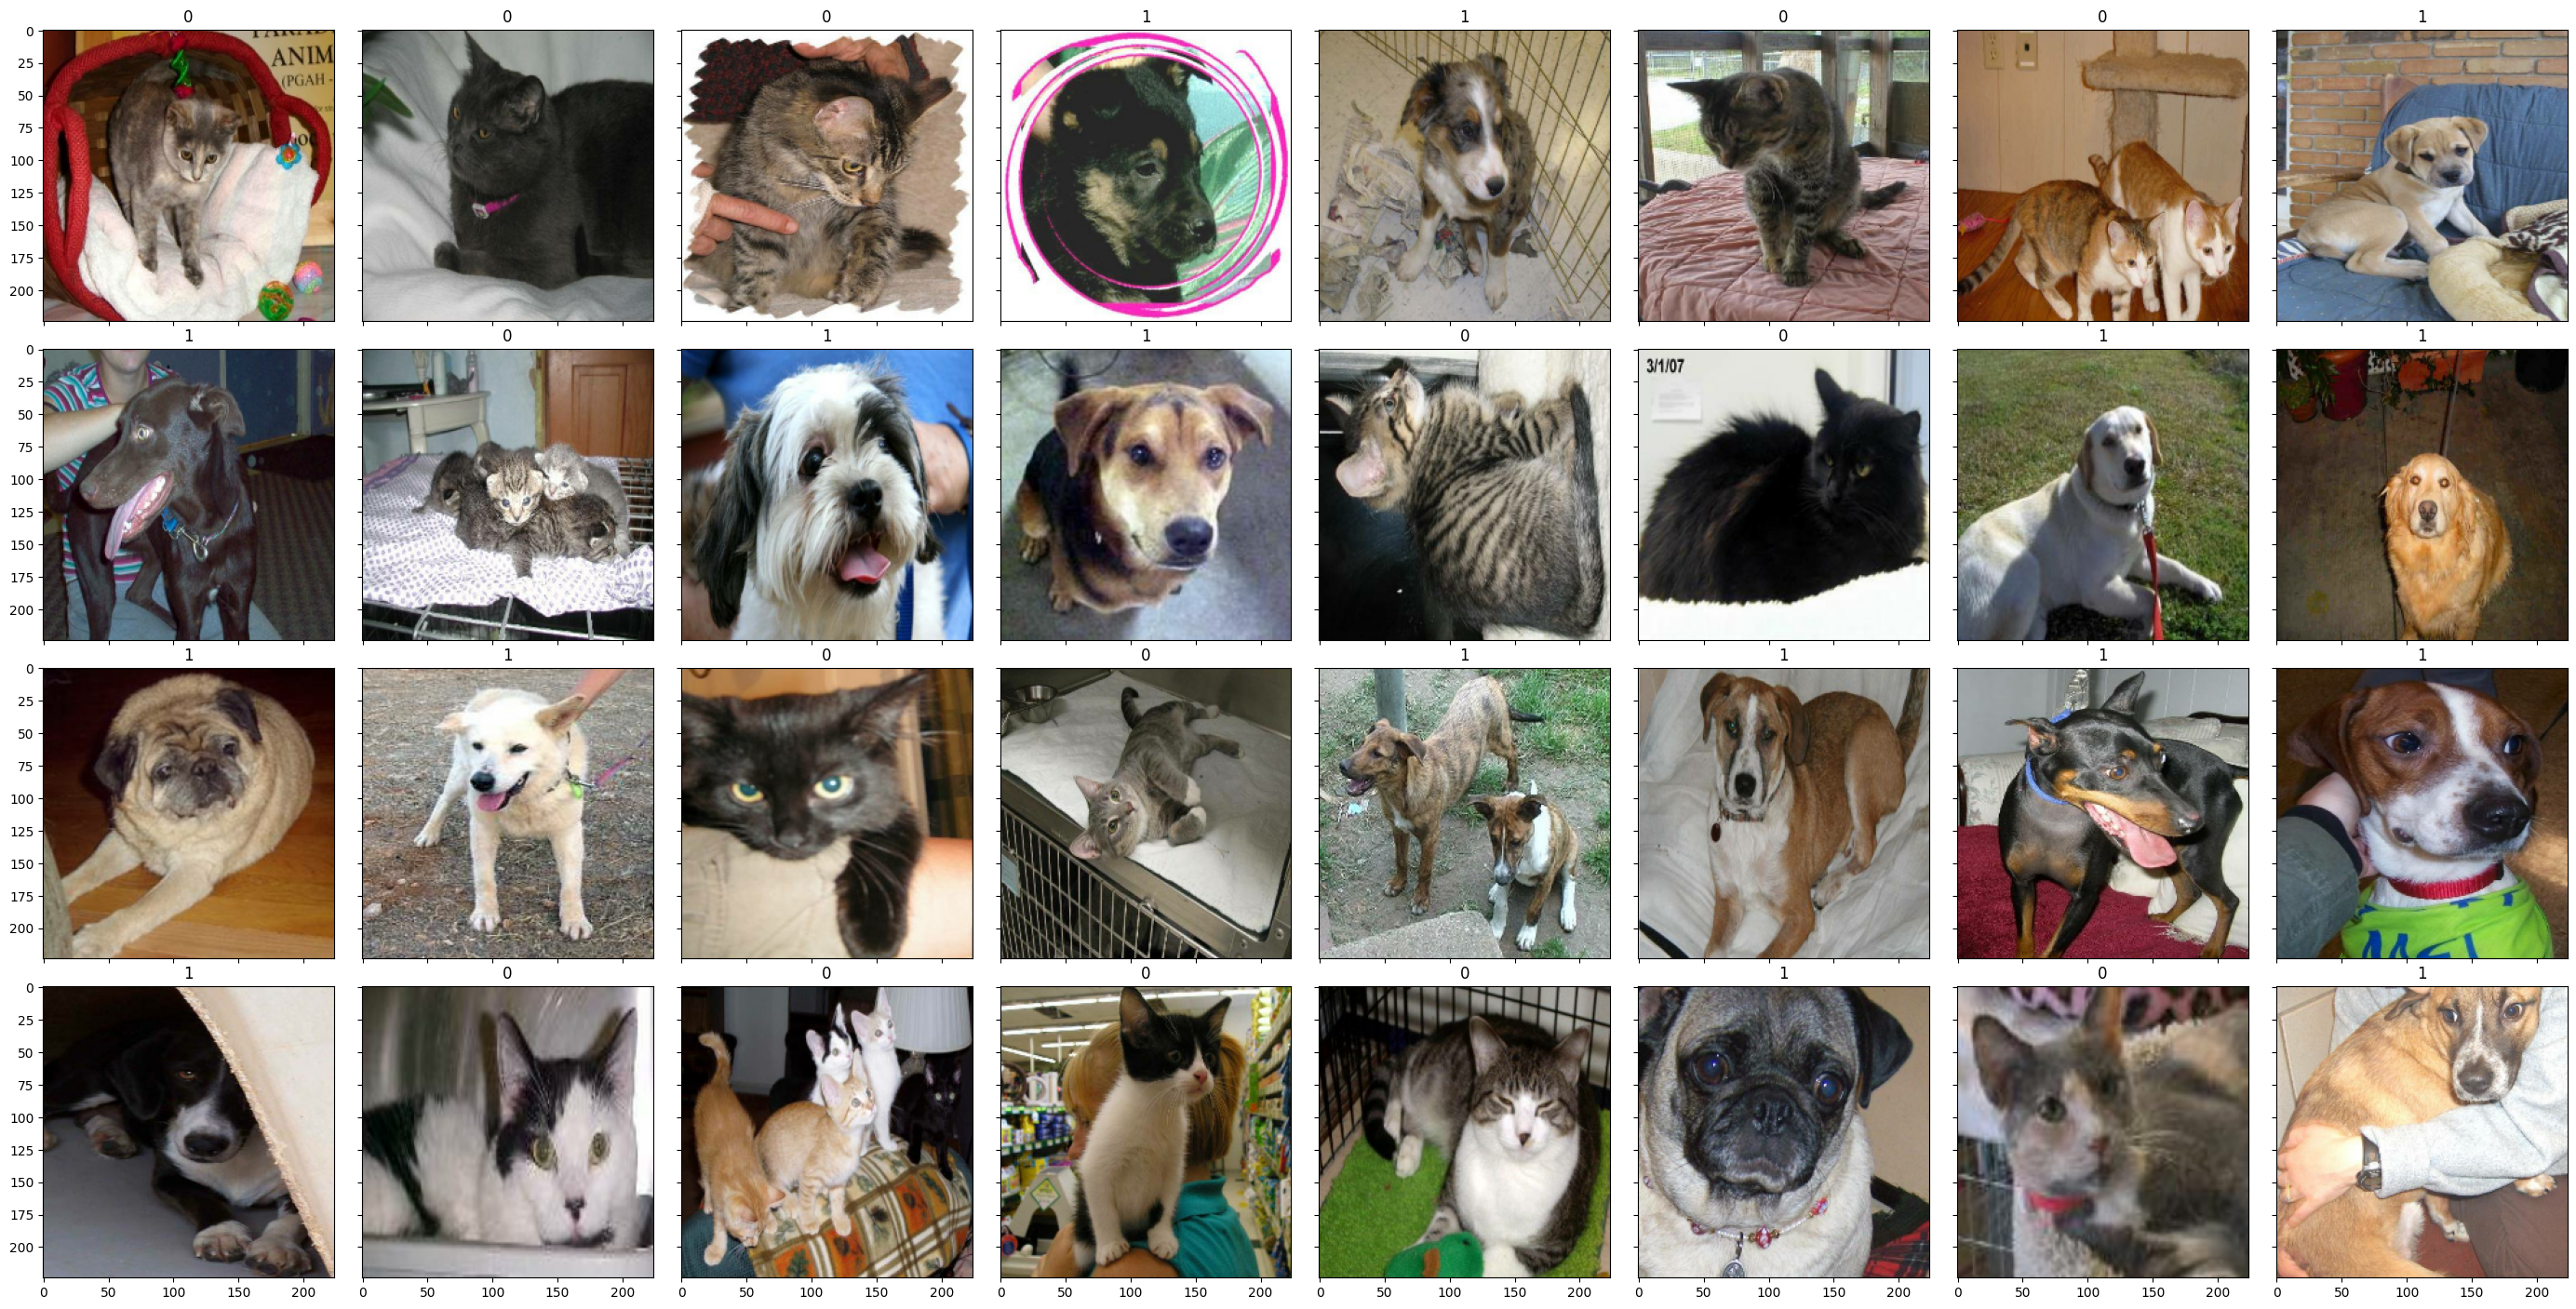

In [ ]:
im_batch_plus_lbl, lbl_batch = next(iter(train_ds))
im_batch = im_batch_plus_lbl

fig = plt.figure(figsize=(35, 35))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )
for i, grid in enumerate(zip(grid, im_batch)):
    ax, im = grid
    ax.imshow(tf.cast(im,tf.int32))
    ax.set_title(lbl_batch[i].numpy(), fontdict=None, loc='center', color = "k")

plt.show()

##CALLBACKS

In [ ]:
def generate_callbacks():
    MODELS_DIR.joinpath('cp').mkdir(parents=True, exist_ok=True)
    MODELS_DIR.joinpath('logs').mkdir(parents=True, exist_ok=True)

    reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.2,
                                            patience=2,
                                            verbose=1,
                                            min_delta=0.000001,
                                            cooldown=0,
                                            min_lr=0.0000001)

    chk_path = MODELS_DIR.joinpath('cp', 'ckpt_{epoch:02d}.ckpt')

    # Ключевые точки обучения. Если save_best_only=True (модель улучшилась), то эти точки сохраняем. save_weights_only=True -сохранение только веса модели.
    checkpointer = tf.keras.callbacks.ModelCheckpoint(chk_path, save_best_only=True, verbose=1, save_weights_only=True)

    # monitor='val_loss' - на основании чего срабатывает (на основании валидационной ошибки). Если валидационная ошибка не уменьшается
    # на протяжении 4 эпох(patience=4), то обучение останавливается. min_delta=0.0001 - на сколько должна улучшиться модель,
    # что-бы мы считали её улучшиной. restore_best_weights=True - запоминает когда была самая лучшая эпоха и после остановки восстановит эту точку.
    stopper = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, min_delta=0.0001, verbose=1)

    # Ведение логирования и запись обучения, каждую эпоху, в csv файл.
    logger = CSVLogger(MODELS_DIR.joinpath("logs", f"training_log.csv"), separator=';', append=True)

    logs = "logs/" + datetime.now().strftime("thresh_%Y%m%d-%H%M%S")
    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                    histogram_freq = 1,
                                                    profile_batch = '200,205')


    callbacks = [reduce_learning_rate,    # автоматическое уменьшение шага обучения
                checkpointer,   # Ключевые точки обучения
                stopper,    # Остановка обучения
                logger,   # Логирование
    ]
    return callbacks

callbacks = generate_callbacks()    # вызываем для перегенирации collbacks.
print('Done')

Done


## Создадим функцию аугоментации.

In [ ]:
# Создадим функцию аугоментации
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),    # Случайное отображение по горизонтали (влево или вправо)
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),         # Случайное вращение
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),             # Случайное изменение размера
    ],
    name='augmentation'

)

## Создадим функцию для показа графиков обучения.

In [ ]:
# Функция для показа графиков обучения
import matplotlib.pyplot as plt

def show_results(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(accuracy)+1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.legend()
    plt.title("Training and validation accuracy")
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.legend()
    plt.title("Training and validation loss")
    plt.show()

# **Самодельная модель без аугоментации.**

## Учим **самодельную модель без аугоментации**.

In [ ]:
# Обучим модель, которую соберём сами.

inputs = tf.keras.Input(shape=IMAGE_SIZE)   # inputs - входной слой модели. В него приходит изображение размером IMAGE_SIZE/
x = inputs/255.
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)   # свёрточные слои
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)                              # слои макспуллинга
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)   # колличество фильтров увеличивается
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)                              # значение ядра свёртки всегда используем 3
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)    # Превращаем выход последней свёртки в одномерный массив
# x = layers.Dropout(0.5)(x)
# слой flatten подаём на полносвязный слой, который имеет один выхход и функцию активации сигмоида (значение от 0 до 1)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# Собираем keras модель. На вход можно подать несколько imputs(в нашем случе вход один) и выходы.
model_no_augm = tf.keras.Model(inputs=inputs, outputs=outputs)

model_no_augm.summary()   # Вывести какую модель мы собрали.

# ОБЯЗАТЕЛЬНО!!! Компилируем модель.

model_no_augm.compile(loss='binary_crossentropy',   # указываем loss функцию, на основании которой будет определяться ошибка
              optimizer='rmsprop',    # определить оптимизатор, который будет оптимизировать нашу модель
              metrics=['accuracy'])   # метрики, на основании которых будем смотреть как хорошо работает модель.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 conv2d_102 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_103 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0     

In [ ]:
# checkpointer = tf.keras.callbacks.ModelCheckpoint(chk_path, save_best_only=True, verbose=1, save_weights_only=True)
# stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, min_delta=0.0001, verbose=1)
# logger = CSVLogger(config.MODEL_DEPLOY_DIR.joinpath(logfile), separator=';', append=True)


history = model_no_augm.fit(
    train_ds,   # тренировочный dataset
    epochs=100,   # количество эпох (эпоха - это один раз просмотреть все тренировочные картинки)
    validation_data=val_ds,   # на чём модель должна валидироваться (валидация идёт после каждой эпохи)
    callbacks=callbacks,    # callbacks - колбеки которые мы настроили
)

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.5208
Epoch 1: val_loss did not improve from 0.03130
75/75 [==============================] - 12s 113ms/step - loss: 0.7154 - accuracy: 0.5208 - val_loss: 0.6939 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5350
Epoch 2: val_loss did not improve from 0.03130
75/75 [==============================] - 10s 128ms/step - loss: 0.6929 - accuracy: 0.5350 - val_loss: 0.6832 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.5742
Epoch 3: val_loss did not improve from 0.03130
75/75 [==============================] - 8s 112ms/step - loss: 0.6810 - accuracy: 0.5742 - val_loss: 0.6520 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.6390 - accuracy: 0.6458
Epoch 4: val_loss did not improve from 0.0313

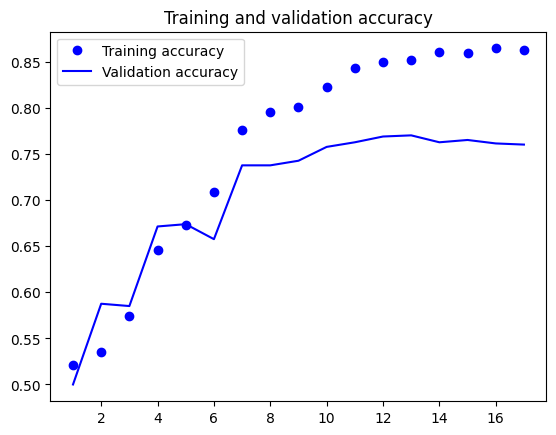

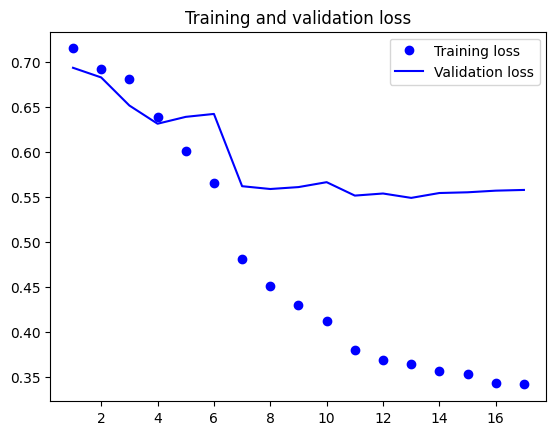

In [ ]:
# Посмотрим графики обучения нашей модели
import matplotlib.pyplot as plt

def show_results(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(accuracy)+1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.legend()
    plt.title("Training and validation accuracy")
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.legend()
    plt.title("Training and validation loss")
    plt.show()

show_results(history)

In [ ]:
# Saving model
# Сохраним нашу модель в формате h5. Это keras формат в виде одного файла.
model_no_augm.save(MODELS_DIR.joinpath('self_made_wo_augm.h5'))

# Если указать без раширения и добавить 'pb' , то модель будет сохранена в формате TensorFlow2
# (файл с расширением .pb и несколько папок с данными)
#model.save(MODELS_DIR.joinpath('self_made_wo_augm'), 'pb')
print("Модель сохранена! ))")

Модель сохранена! ))


## Проверка собранной **своей модели с аугументацией**.

In [ ]:
model_no_augm = tf.keras.models.load_model(MODELS_DIR.joinpath('self_made_wo_augm.h5'))   #Загрузим нашу модель

In [ ]:
# Проведём проверку на тестовой выборке

test_loss, test_acc =  model_no_augm.evaluate(test_ds)   # Проводим тестирование на тестовой выборке (test_ds- мы его создали в начале)
# test_loss - это значение функции потерь, полученное при оценке качества модели. Чем ниже, тем лучше.
# test_acc - это точность модели на тестовых данных, она вычисляется путём сравнения предсказанных значений
# модели с реальными тестовыми данными. Чем выше - тем лучше модель работает
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 2s 67ms/step - loss: 0.5449 - accuracy: 0.7387
Test accuracy: 0.739


In [ ]:
import time

start_time = time.time()                                      # Зафиксируем текущее время.
output=model_no_augm.predict(img_tensor)    # Предскажем результат загруженного изображения нашей моделью.
delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print ('cats=0, dog = 1, predict =', output)  # Выведем предсказание.

1/1 [==============================] - 0s 80ms/step
---0.1197667121887207 seconds ---
cats=0, dog = 1, predict = [[0.01460738]]


## Результат теста собранной **своей модели с аугументацией**.##

In [ ]:
df_results.loc[0] = ['Self_model_wo_augm', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_ResNet50  0.477064   0.76750      0.551422
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.830235
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.380936
2             Self_model_w_augm  0.478171   0.77750      0.216836
1             Self_model_w_augm  0.478171   0.77750      0.143368
0            Self_model_wo_augm  0.544904   0.73875      0.119767

# **Своя модель с аугументацией**.

## Соберём **свою модель с аугументацией**.

In [ ]:

# Теперь добавим в нашу модель слой аугоментации, в нашу модель.

inputs = tf.keras.Input(shape=IMAGE_SIZE)
x = data_augmentation(inputs)   # Слой аугументацию. Ствим после входного слоя, но перед нормализацией.
x = x/255.
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
# x = layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_augm = tf.keras.Model(inputs=inputs, outputs=outputs)

model_augm.summary()

model_augm.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print('[+] Model compiled!')
callbacks = generate_callbacks()
print('[+] Callbacks done')
history = model_augm.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, None)    0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 conv2d_107 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_108 (Conv2D)         (None, 109, 109, 64)      1849

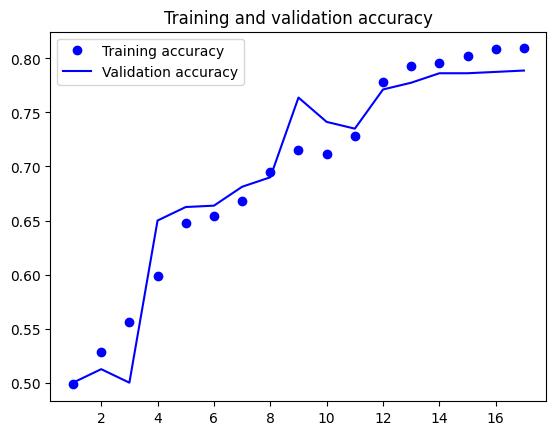

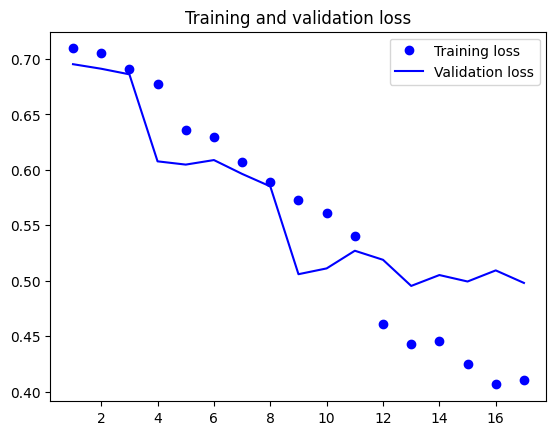

In [ ]:
show_results(history)

In [ ]:
# Saving model

model_augm.save(MODELS_DIR.joinpath('self_made_w_augm.h5'))
print("Модель сохранена!")

Модель сохранена!


## Проверка собранной **своей модели с аугументацией**.

In [ ]:
model_augm = tf.keras.models.load_model(MODELS_DIR.joinpath('self_made_w_augm.h5'))   #Загрузим нашу модель

In [ ]:
test_loss, test_acc = model_augm.evaluate(test_ds)   # Проведём тестирование на тестовом dataset
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 2s 70ms/step - loss: 0.4782 - accuracy: 0.7775
Test accuracy: 0.777


In [ ]:
import time

start_time = time.time()                                      # Зафиксируем текущее время.
output=model_augm.predict(img_tensor)    # Предскажем результат загруженного изображения нашей моделью.
delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print ('cats=0, dog = 1, predict =', output)  # Выведем предсказание.

1/1 [==============================] - 0s 86ms/step
---0.14336824417114258 seconds ---
cats=0, dog = 1, predict = [[0.07900898]]


## Результат теста собранной **своей модели с аугументацией**.##

In [ ]:
df_results.loc[1] = ['Self_model_w_augm', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_ResNet50  0.477064   0.76750      0.551422
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.830235
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.380936
2             Self_model_w_augm  0.478171   0.77750      0.216836
1             Self_model_w_augm  0.478171   0.77750      0.143368

# **VGG16 + feature vectors**

## Обучение выходного слоя на feature vectors предобученной модели

In [ ]:
import numpy as np

conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3),
)

inp = tf.keras.layers.Input(shape=IMAGE_SIZE, name='Image_input')
x = inp/255.
outp = conv_base(x)

fv_model = tf.keras.models.Model(inputs=inp, outputs=outp, name='Feature_vector_Model')

fv_model.summary()

# Собрали модель : делаемм вход, нормализацию и на выходе не делаем преобразование
# а получем вектора (формат 7,7,512 - изображение 7 на 7 и 512 слоёв)



58889256/58889256 [==============================] - 0s 0us/step
Model: "Feature_vector_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in tqdm(dataset):
        features = fv_model.predict(images, verbose=0)    # подаём в fv_model изображения из нашего dataset
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)   # собираем масив фичей и масив меток

train_features, train_labels = get_features_and_labels(train_ds)    # подаём наш тренировочный dataset
val_features, val_labels = get_features_and_labels(val_ds)

100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


In [ ]:
train_features.shape

(2400, 7, 7, 512)

In [ ]:
inputs = tf.keras.Input(shape=(7,7,512))    # входной слой формата 7, 7, 512
x = tf.keras.layers.Flatten()(inputs)   # слой сглаживания
x = tf.keras.layers.Dense(256)(x)   # слой flatten подаём на полносвязный слой, который имеет 256 выходов
x = tf.keras.layers.Dropout(0.5)(x)   # Этот слой раз за эпоху отбрасывает часть весов, за счёт этого модель не будет переобучаться
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)   # полносвязный слой, который имеет один выход
                                                              # и функцию активации сигмоида (значение от 0 до 1)
# Собираем модель
model_pretrained_head = tf.keras.Model(inputs, outputs, name='FV_pretrained_head')
# Компилируем модель
model_pretrained_head.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=['accuracy'])
# Перегенерируем коллбеки
callbacks = generate_callbacks()

# Обучаем модель
history = model_pretrained_head.fit(
    train_features, train_labels,
    epochs=100,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
)

Epoch 1/100
65/75 [=========================>....] - ETA: 0s - loss: 7.5875 - accuracy: 0.7202
Epoch 1: val_loss improved from inf to 10.34429, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_01.ckpt
75/75 [==============================] - 2s 12ms/step - loss: 7.2774 - accuracy: 0.7204 - val_loss: 10.3443 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 2/100
67/75 [=========================>....] - ETA: 0s - loss: 2.6072 - accuracy: 0.8475
Epoch 2: val_loss improved from 10.34429 to 1.80543, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_02.ckpt
75/75 [==============================] - 1s 8ms/step - loss: 2.6954 - accuracy: 0.8442 - val_loss: 1.8054 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 3/100
64/75 [========================>.....] - ETA: 0s - loss: 2.2391 - accuracy: 0.8638
Epoch 3: val_loss improved from 1.80543 to 1.69595, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryCla

In [ ]:
model_pretrained_head.summary()

Model: "FV_pretrained_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


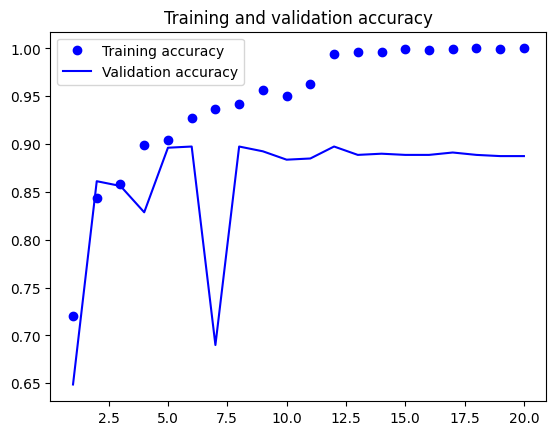

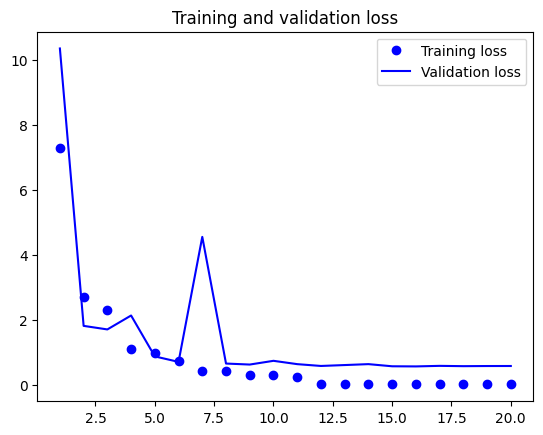

In [ ]:
show_results(history)

In [ ]:
#making united model

model_united_1_stage = tf.keras.Sequential([fv_model, model_pretrained_head])   # Соеденим в ону модель
# вставив в неё fv_model и модель классифицирующую голову model_pretrained_head.

# посмотрим что мы собрали
model_united_1_stage.summary()
# Скомпилируем модель
model_united_1_stage.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_vector_Model (Funct  (None, 7, 7, 512)        14714688  
 ional)                                                          
                                                                 
 FV_pretrained_head (Functio  (None, 1)                6423041   
 nal)                                                            
                                                                 
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Saving model

model_united_1_stage.save(MODELS_DIR.joinpath('model_pretrained_1_stage.h5'))
print("Модель сохранена!)))")

Модель сохранена!)))


## Проверка собранной модели **VGG16 + feature vectors**

In [ ]:
model_pretrained_1_stage = tf.keras.models.load_model(MODELS_DIR.joinpath('model_pretrained_1_stage.h5'))   #Загрузим нашу модель

In [ ]:
test_loss, test_acc = model_pretrained_1_stage.evaluate(test_ds)   # Проведём тестирование на тестовом dataset
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 7s 122ms/step - loss: 0.3722 - accuracy: 0.9200
Test accuracy: 0.920


In [ ]:
import time

start_time = time.time()                                      # Зафиксируем текущее время.
output=model_pretrained_1_stage.predict(img_tensor)    # Предскажем результат загруженного изображения нашей моделью.
delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print ('cats=0, dog = 1, predict =', output)  # Выведем предсказание.

1/1 [==============================] - 1s 688ms/step
---0.7399322986602783 seconds ---
cats=0, dog = 1, predict = [[1.4708918e-21]]


## Результат теста собранной модели **VGG16 + feature vectors**##

In [ ]:
df_results.loc[2] = ['Pretrained_fv_model_1_stage', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_ResNet50  0.477064   0.76750      0.551422
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.830235
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.380936
2   Pretrained_fv_model_1_stage  0.372191   0.92000      0.739932
1             Self_model_w_augm  0.478171   0.77750      0.143368
0            Self_model_wo_augm  0.544904   0.73875      0.119767

#**MobileNetV2**

## Ниже представлено обучение с трансферлернингом

1. Подцепляем к предобученному замороженному backbone выходную голову и обучаем
2. Размораживаем часть ближайших слоев к голове и малым шагом дообучаем их

In [ ]:
# conv_base = keras.applications.vgg16.VGG16(
#     weights="imagenet",
#     include_top=False,
#     input_shape=(224,224,3)
# )

# Создадим свёрточный слой на основании MobileNetV2
conv_base = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE,
                                           include_top=False,
                                           pooling='avg',
                                           alpha=1,
                                           )

# Передаём этот параметр, чтобы модель изначально не обучалась
conv_base.trainable=False


#data_augmentation = tf.keras.models.Sequential(
#    [
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
#     tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
#    ],
#    name='augmentation'

#)

# Создаём модель
input = tf.keras.Input(IMAGE_SIZE)    # входной слой
x = data_augmentation(input)          # Слой аугументации
x = x/255.                            # Нормализация
x = conv_base(x)                      # Созданный свёрточный слой
x = tf.keras.layers.Flatten()(x)      # Слой сглаживания
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)    # полносвязный слой, который имеет один выход
                                                              # и функцию активации сигмоида (значение от 0 до 1)

# Создаём модель
model_two_steps = tf.keras.Model(inputs=input, outputs=output, name="Two_steps_learning")
# Смотрим какую модель создали
model_two_steps.summary()
# Компилируем мордель
model_two_steps.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'],)
#Перегенерируем колбеки
callbacks = generate_callbacks()

#Обучаем модель
history = model_two_steps.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
)


Model: "Two_steps_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, None)    0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 1)          

In [ ]:
# Unfreezing model

conv_base.trainable=True    # Разморозим свёрточный слой полностью

for layer in conv_base.layers[:-40]:    # Идём по слоям свёрточного слоя до последних 40 слоёв
    layer.trainable=False               # Замораживаем эти слои

# КОМПИЛИРУЕМ МОДЕЛЬ!!!
# так как мы поработали и изменили слой сети.
model_two_steps.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=["accuracy"])
# Перезапустим коллбеки
callbacks = generate_callbacks()
# Проведём обучение
history = model_two_steps.fit(
     train_ds,
     epochs=30,
     validation_data=val_ds,
     callbacks=callbacks)


Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9471
Epoch 1: val_loss improved from inf to 0.08323, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_01.ckpt
75/75 [==============================] - 19s 135ms/step - loss: 0.1301 - accuracy: 0.9471 - val_loss: 0.0832 - val_accuracy: 0.9725 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9638
Epoch 2: val_loss did not improve from 0.08323
75/75 [==============================] - 9s 116ms/step - loss: 0.0928 - accuracy: 0.9638 - val_loss: 0.1095 - val_accuracy: 0.9650 - lr: 1.0000e-04
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9817
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 3: val_loss did not improve from 0.08323
75/75 [==============================] - 9s 117ms/step - loss: 0.0515 - accuracy: 0.9817 - val_loss:

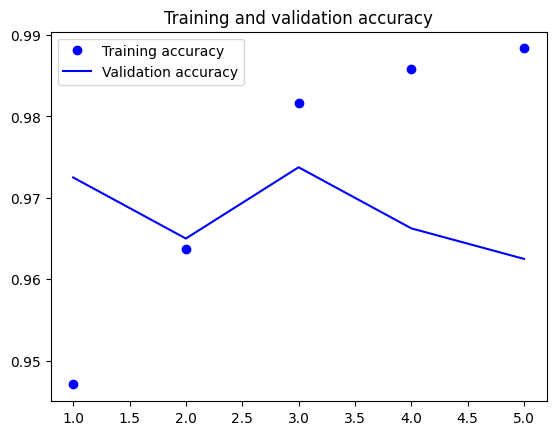

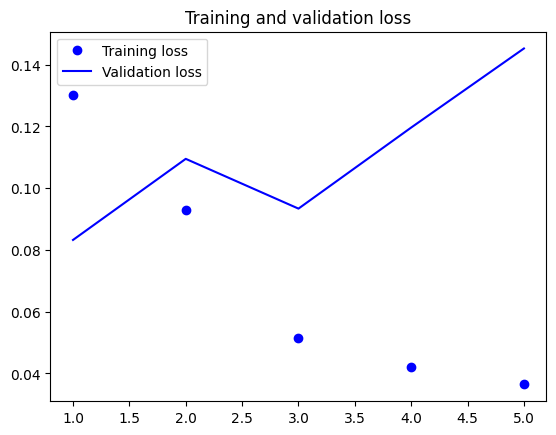

In [ ]:
show_results(history)

In [ ]:
# Saving model

model_two_steps.save(MODELS_DIR.joinpath('model_two_steps.h5'))
print("Модель MobileNetV2 сохранена! ))")

Модель MobileNetV2 сохранена! ))


## Проверка дообученной модели **MobileNetV2**

In [ ]:
model_MobileNetV2 = tf.keras.models.load_model(MODELS_DIR.joinpath('model_two_steps.h5'))   #Загрузим нашу модель

In [ ]:
test_loss, test_acc = model_MobileNetV2.evaluate(test_ds)   # Проведём тестирование на тестовом dataset
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 3s 64ms/step - loss: 0.0440 - accuracy: 0.9875
Test accuracy: 0.988


In [ ]:
import time

start_time = time.time()                                      # Зафиксируем текущее время.
output=model_MobileNetV2.predict(img_tensor)    # Предскажем результат загруженного изображения нашей моделью.
delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print ('cats=0, dog = 1, predict =', output)  # Выведем предсказание.

1/1 [==============================] - 1s 1s/step
---1.3920340538024902 seconds ---
cats=0, dog = 1, predict = [[0.0015636]]


## Результат теста дообученной модели **MobileNetV2**

In [ ]:
df_results.loc[3] = ['Pretrained_MobileNetV2', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_ResNet50  0.477064   0.76750      0.551422
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.830235
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.380936
2   Pretrained_fv_model_1_stage  0.372191   0.92000      0.739932
1             Self_model_w_augm  0.478171   0.77750      0.143368
0            Self_model_wo_augm  0.544904   0.73875      0.119767
3        Pretrained_MobileNetV2  0.043954   0.98750      1.392034

# **Xception**

## Oбучение с трансферлернингом модели **Xception**.

In [ ]:

# Создадим свёрточный слой на основании Xception

conv_base = tf.keras.applications.Xception(
    include_top=False,
    input_shape=IMAGE_SIZE,
    pooling='avg',


)

# Передаём этот параметр, чтобы модель изначально не обучалась
conv_base.trainable=False

# Создаём модель
input = tf.keras.Input(IMAGE_SIZE)    # входной слой
x = data_augmentation(input)          # Слой аугументации
x = x/255.                            # Нормализация
x = conv_base(x)                      # Созданный свёрточный слой
x = tf.keras.layers.Flatten()(x)      # Слой сглаживания
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)    # полносвязный слой, который имеет один выход
                                                              # и функцию активации сигмоида (значение от 0 до 1)

# Создаём модель
model_Xception = tf.keras.Model(inputs=input, outputs=output, name="Xception_learning")
# Смотрим какую модель создали
model_Xception.summary()
# Компилируем мордель
model_Xception.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'],)
#Перегенерируем колбеки
callbacks = generate_callbacks()

#Обучаем модель
history = model_Xception.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
)


Model: "Xception_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                 

In [ ]:
# Unfreezing model

conv_base.trainable=True    # Разморозим свёрточный слой полностью

for layer in conv_base.layers[:-40]:    # Идём по слоям свёрточного слоя до последних 40 слоёв
    layer.trainable=False               # Замораживаем эти слои

# КОМПИЛИРУЕМ МОДЕЛЬ!!!
# так как мы поработали и изменили слой сети.
model_Xception.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=["accuracy"])
# Перезапустим коллбеки
callbacks = generate_callbacks()
# Проведём обучение
history = model_Xception.fit(
     train_ds,
     epochs=30,
     validation_data=val_ds,
     callbacks=callbacks)


Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9508
Epoch 1: val_loss improved from inf to 0.04088, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_01.ckpt
75/75 [==============================] - 39s 311ms/step - loss: 0.1267 - accuracy: 0.9508 - val_loss: 0.0409 - val_accuracy: 0.9862 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9712
Epoch 2: val_loss improved from 0.04088 to 0.02541, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_02.ckpt
75/75 [==============================] - 23s 303ms/step - loss: 0.0779 - accuracy: 0.9712 - val_loss: 0.0254 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9842
Epoch 3: val_loss did not improve from 0.02541
75/75 [==============================] - 22s 288ms/step - loss: 0.0510 

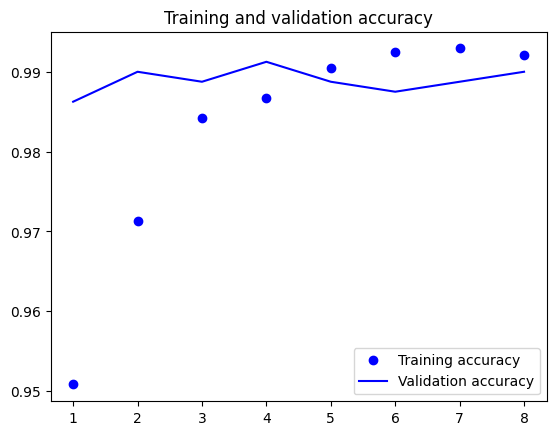

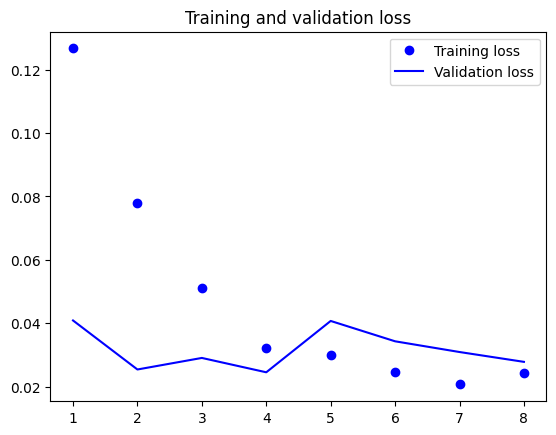

In [ ]:
show_results(history)

In [ ]:
# Saving model

model_Xception.save(MODELS_DIR.joinpath('model_Xception.h5'))
print("Модель Xception сохранена! ))")

Модель Xception сохранена! ))


## Проверка дообученной модели **Xception**

In [ ]:
model_Xception = tf.keras.models.load_model(MODELS_DIR.joinpath('model_Xception.h5'))   #Загрузим нашу модель

In [ ]:
test_loss, test_acc = model_Xception.evaluate(test_ds)   # Проведём тестирование на тестовом dataset
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 4s 122ms/step - loss: 0.0202 - accuracy: 0.9937
Test accuracy: 0.994


In [ ]:
import time

start_time = time.time()                                      # Зафиксируем текущее время.
output = model_Xception.predict(img_tensor)    # Предскажем результат загруженного изображения нашей моделью.
delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print ('cats=0, dog = 1, predict =', output)  # Выведем предсказание.

1/1 [==============================] - 1s 700ms/step
---0.7468411922454834 seconds ---
cats=0, dog = 1, predict = [[0.00213634]]


## Результат теста дообученной модели **Xception**

In [ ]:
df_results.loc[4] = ['Pretrained_model_Xception', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_Xception  0.020234   0.99375      0.746841
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.830235
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.380936
2   Pretrained_fv_model_1_stage  0.372191   0.92000      0.739932
1             Self_model_w_augm  0.478171   0.77750      0.143368
0            Self_model_wo_augm  0.544904   0.73875      0.119767
3        Pretrained_MobileNetV2  0.043954   0.98750      1.392034

# **ResNet50**

## Oбучение с трансферлернингом модели **ResNet50**.

In [ ]:
# Создадим свёрточный слой на основании ResNet50

conv_base = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMAGE_SIZE,
    pooling='avg',


)

# Передаём этот параметр, чтобы модель изначально не обучалась
conv_base.trainable=False

# Создаём модель
input = tf.keras.Input(IMAGE_SIZE)    # входной слой
x = data_augmentation(input)          # Слой аугументации
x = x/255.                            # Нормализация
x = conv_base(x)                      # Созданный свёрточный слой
x = tf.keras.layers.Flatten()(x)      # Слой сглаживания
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)    # полносвязный слой, который имеет один выход
                                                              # и функцию активации сигмоида (значение от 0 до 1)

# Создаём модель
model_ResNet50 = tf.keras.Model(inputs=input, outputs=output, name="ResNet50_learning")
# Смотрим какую модель создали
model_ResNet50.summary()
# Компилируем мордель
model_ResNet50.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'],)
#Перегенерируем колбеки
callbacks = generate_callbacks()

#Обучаем модель
history = model_ResNet50.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
)


94765736/94765736 [==============================] - 0s 0us/step
Model: "ResNet50_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, None)    0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)            

In [ ]:
# Unfreezing model

conv_base.trainable=True    # Разморозим свёрточный слой полностью

for layer in conv_base.layers[:-40]:    # Идём по слоям свёрточного слоя до последних 40 слоёв
    layer.trainable=False               # Замораживаем эти слои

# КОМПИЛИРУЕМ МОДЕЛЬ!!!
# так как мы поработали и изменили слой сети.
model_ResNet50.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=["accuracy"])
# Перезапустим коллбеки
callbacks = generate_callbacks()
# Проведём обучение
history = model_ResNet50.fit(
     train_ds,
     epochs=30,
     validation_data=val_ds,
     callbacks=callbacks)


Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.5663
Epoch 1: val_loss improved from inf to 0.78160, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_01.ckpt
75/75 [==============================] - 36s 225ms/step - loss: 0.9009 - accuracy: 0.5663 - val_loss: 0.7816 - val_accuracy: 0.5150 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.6033
Epoch 2: val_loss improved from 0.78160 to 0.63164, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_02.ckpt
75/75 [==============================] - 15s 203ms/step - loss: 0.7057 - accuracy: 0.6033 - val_loss: 0.6316 - val_accuracy: 0.6413 - lr: 1.0000e-04
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.6530 - accuracy: 0.6513
Epoch 3: val_loss did not improve from 0.63164
75/75 [==============================] - 17s 224ms/step - loss: 0.6530 

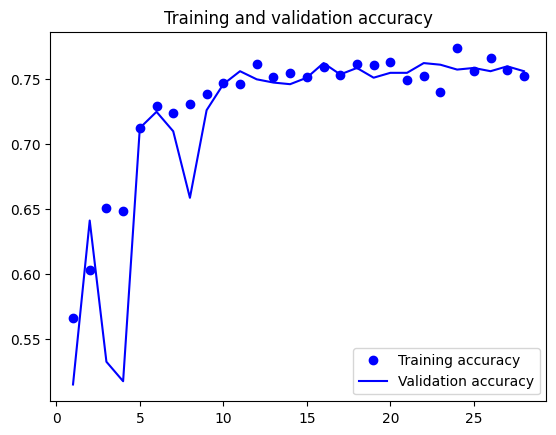

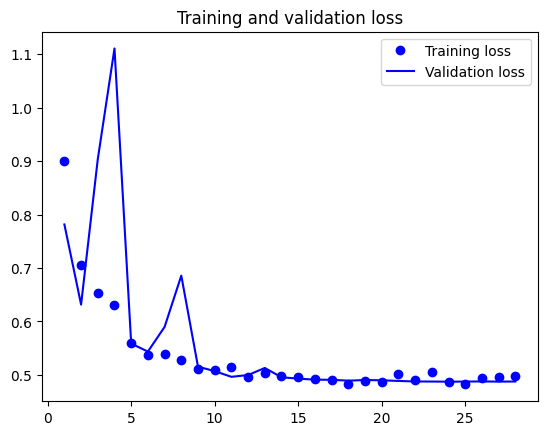

In [ ]:
show_results(history)

In [ ]:
# Сохраним модель ResNet50
model_ResNet50.save(MODELS_DIR.joinpath('model_ResNet50.h5'))
print("Модель ResNet50 сохранена! ))")

Модель ResNet50 сохранена! ))


## Проверка дообученной модели **ResNet50**

In [ ]:
model_ResNet50 = tf.keras.models.load_model(MODELS_DIR.joinpath('model_ResNet50.h5'))   #Загрузим нашу модель

In [ ]:
test_loss, test_acc = model_ResNet50.evaluate(test_ds)   # Проведём тестирование на тестовом dataset
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 4s 113ms/step - loss: 0.4771 - accuracy: 0.7675
Test accuracy: 0.767


In [ ]:
import time

start_time = time.time()                                      # Зафиксируем текущее время.
output = model_ResNet50(img_tensor)            # Предскажем результат загруженного изображения нашей моделью.
delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print ('cats=0, dog = 1, predict =', output)   # Выведем предсказание.

---0.1175088882446289 seconds ---
cats=0, dog = 1, predict = tf.Tensor([[0.18407716]], shape=(1, 1), dtype=float32)


## Результат теста дообученной модели **ResNet50**



In [ ]:
df_results.loc[4] = ['Pretrained_model_ResNet50', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_ResNet50  0.477064   0.76750      0.117509
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.830235
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.380936
2   Pretrained_fv_model_1_stage  0.372191   0.92000      0.739932
1             Self_model_w_augm  0.478171   0.77750      0.143368
0            Self_model_wo_augm  0.544904   0.73875      0.119767
3        Pretrained_MobileNetV2  0.043954   0.98750      1.392034

# **InceptionV3**

## Oбучение с трансферлернингом модели **InceptionV3**.

In [ ]:
# Создадим свёрточный слой на основании InceptionV3

conv_base = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=IMAGE_SIZE,
    pooling='avg',


)

# Передаём этот параметр, чтобы модель изначально не обучалась
conv_base.trainable=False

# Создаём модель
input = tf.keras.Input(IMAGE_SIZE)    # входной слой
x = data_augmentation(input)          # Слой аугументации
x = x/255.                            # Нормализация
x = conv_base(x)                      # Созданный свёрточный слой
x = tf.keras.layers.Flatten()(x)      # Слой сглаживания
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)    # полносвязный слой, который имеет один выход
                                                              # и функцию активации сигмоида (значение от 0 до 1)

# Создаём модель
model_InceptionV3 = tf.keras.Model(inputs=input, outputs=output, name="InceptionV3_learning")
# Смотрим какую модель создали
model_InceptionV3.summary()
# Компилируем мордель
model_InceptionV3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'],)
#Перегенерируем колбеки
callbacks = generate_callbacks()

#Обучаем модель
history = model_InceptionV3.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
)


87910968/87910968 [==============================] - 0s 0us/step
Model: "InceptionV3_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, None)    0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1)         

In [ ]:
# Unfreezing model

conv_base.trainable=True    # Разморозим свёрточный слой полностью

for layer in conv_base.layers[:-40]:    # Идём по слоям свёрточного слоя до последних 40 слоёв
    layer.trainable=False               # Замораживаем эти слои

# КОМПИЛИРУЕМ МОДЕЛЬ!!!
# так как мы поработали и изменили слой сети.
model_InceptionV3.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=["accuracy"])
# Перезапустим коллбеки
callbacks = generate_callbacks()
# Проведём обучение
history = model_InceptionV3.fit(
     train_ds,
     epochs=30,
     validation_data=val_ds,
     callbacks=callbacks)


Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9729
Epoch 1: val_loss improved from inf to 0.03994, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_01.ckpt
75/75 [==============================] - 23s 165ms/step - loss: 0.0753 - accuracy: 0.9729 - val_loss: 0.0399 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9812
Epoch 2: val_loss improved from 0.03994 to 0.03847, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_02.ckpt
75/75 [==============================] - 10s 137ms/step - loss: 0.0540 - accuracy: 0.9812 - val_loss: 0.0385 - val_accuracy: 0.9912 - lr: 1.0000e-04
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9837
Epoch 3: val_loss improved from 0.03847 to 0.03569, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/Bi

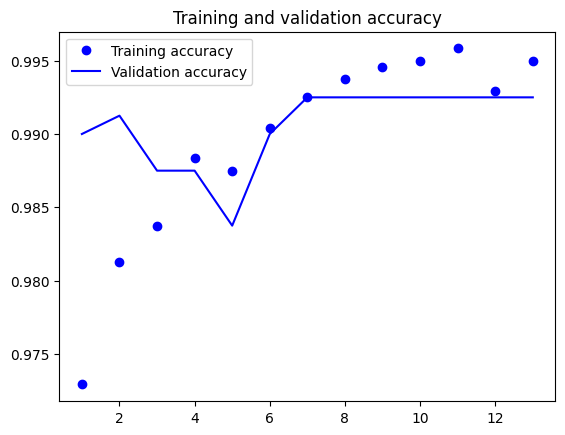

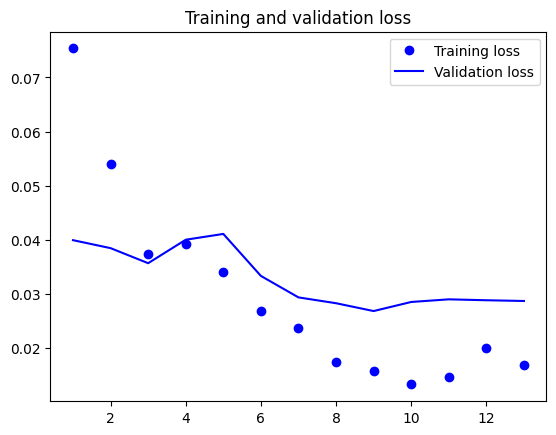

In [ ]:
show_results(history)

In [ ]:
# Saving model

model_InceptionV3.save(MODELS_DIR.joinpath('model_InceptionV3.h5'))
print("Модель InceptionV3 сохранена! ))")

Модель InceptionV3 сохранена! ))


## Проверка дообученной модели **InceptionV3**

In [ ]:
model_InceptionV3 = tf.keras.models.load_model(MODELS_DIR.joinpath('model_InceptionV3.h5'))   #Загрузим нашу модель

In [ ]:
test_loss, test_acc = model_InceptionV3.evaluate(test_ds)   # Проведём тестирование на тестовом dataset
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 4s 104ms/step - loss: 0.0112 - accuracy: 0.9950
Test accuracy: 0.995


In [ ]:
import time

start_time = time.time()                                      # Зафиксируем текущее время.
output = model_InceptionV3(img_tensor)            # Предскажем результат загруженного изображения нашей моделью.
delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print ('cats=0, dog = 1, predict =', output)   # Выведем предсказание.

---0.18595409393310547 seconds ---
cats=0, dog = 1, predict = tf.Tensor([[0.00125856]], shape=(1, 1), dtype=float32)


## Результат теста дообученной модели **InceptionV3**



In [ ]:
df_results.loc[5] = ['Pretrained_model_InceptionV3', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_ResNet50  0.477064   0.76750      0.117509
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.185954
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.380936
2   Pretrained_fv_model_1_stage  0.372191   0.92000      0.739932
1             Self_model_w_augm  0.478171   0.77750      0.143368
0            Self_model_wo_augm  0.544904   0.73875      0.119767
3        Pretrained_MobileNetV2  0.043954   0.98750      1.392034

# **DenseNet121**

## Дообучим модель **DenseNet121**

In [ ]:
# Создадим свёрточный слой на основании DenseNet121

conv_base = tf.keras.applications.DenseNet121(
    include_top=False,
    input_shape=IMAGE_SIZE,
    pooling='avg',


)

# Передаём этот параметр, чтобы модель изначально не обучалась
conv_base.trainable=False

# Создаём модель
input = tf.keras.Input(IMAGE_SIZE)    # входной слой
x = data_augmentation(input)          # Слой аугументации
x = x/255.                            # Нормализация
x = conv_base(x)                      # Созданный свёрточный слой
x = tf.keras.layers.Flatten()(x)      # Слой сглаживания
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)    # полносвязный слой, который имеет один выход
                                                              # и функцию активации сигмоида (значение от 0 до 1)

# Создаём модель
model_DenseNet121 = tf.keras.Model(inputs=input, outputs=output, name="DenseNet121_learning")
# Смотрим какую модель создали
model_DenseNet121.summary()
# Компилируем мордель
model_DenseNet121.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'],)
#Перегенерируем колбеки
callbacks = generate_callbacks()

#Обучаем модель
history = model_DenseNet121.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
)


29084464/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, None)    0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)         

In [ ]:
# Unfreezing model

conv_base.trainable=True    # Разморозим свёрточный слой полностью

for layer in conv_base.layers[:-40]:    # Идём по слоям свёрточного слоя до последних 40 слоёв
    layer.trainable=False               # Замораживаем эти слои

# КОМПИЛИРУЕМ МОДЕЛЬ!!!
# так как мы поработали и изменили слой сети.
model_DenseNet121.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=["accuracy"])
# Перезапустим коллбеки
callbacks = generate_callbacks()
# Проведём обучение
history = model_DenseNet121.fit(
     train_ds,
     epochs=30,
     validation_data=val_ds,
     callbacks=callbacks)


Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9613
Epoch 1: val_loss improved from inf to 0.04516, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_01.ckpt
75/75 [==============================] - 26s 187ms/step - loss: 0.0909 - accuracy: 0.9613 - val_loss: 0.0452 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9792
Epoch 2: val_loss improved from 0.04516 to 0.03567, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/BinaryClassification/cp/ckpt_02.ckpt
75/75 [==============================] - 12s 162ms/step - loss: 0.0620 - accuracy: 0.9792 - val_loss: 0.0357 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9812
Epoch 3: val_loss improved from 0.03567 to 0.03308, saving model to drive/MyDrive/Colab Notebooks/CV/CV_HW_1/Models/Bi

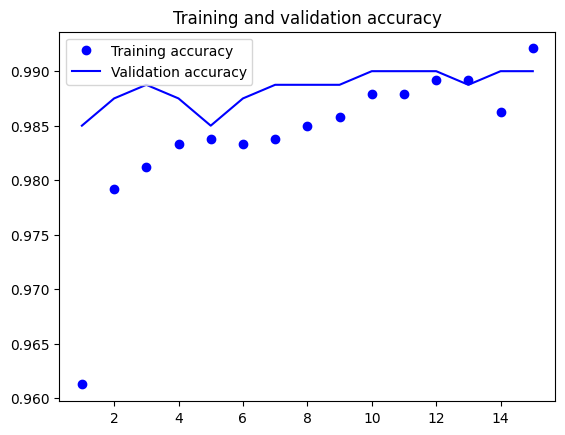

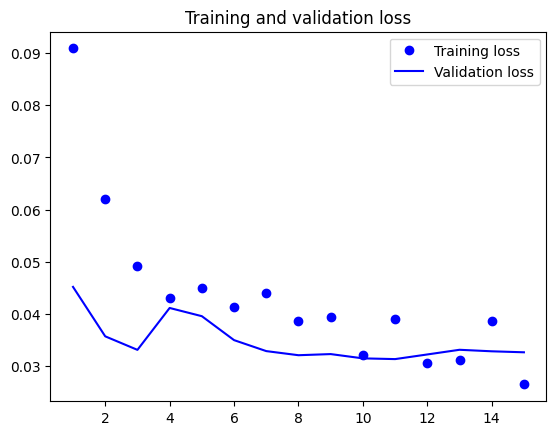

In [ ]:
show_results(history)

In [ ]:
# Saving model

model_DenseNet121.save(MODELS_DIR.joinpath('model_DenseNet121.h5'))
print("Модель DenseNet121 сохранена! ))")

Модель DenseNet121 сохранена! ))


## Проверка дообученной модели **DenseNet121**

In [ ]:
model_DenseNet121 = tf.keras.models.load_model(MODELS_DIR.joinpath('model_DenseNet121.h5'))   #Загрузим нашу модель

In [ ]:
test_loss, test_acc = model_DenseNet121.evaluate(test_ds)   # Проведём тестирование на тестовом dataset
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 6s 129ms/step - loss: 0.0162 - accuracy: 0.9912
Test accuracy: 0.991


In [ ]:
import time

start_time = time.time()                                      # Зафиксируем текущее время.
output = model_DenseNet121(img_tensor)            # Предскажем результат загруженного изображения нашей моделью.
delta_time = time.time() - start_time                         # Посчитаем и сохраним, сколько на это ушло времени.

print ("---%s seconds ---" % (delta_time))                    # Выведем сколько секунд.
print ('cats=0, dog = 1, predict =', output)   # Выведем предсказание.

---0.23162031173706055 seconds ---
cats=0, dog = 1, predict = tf.Tensor([[0.00110565]], shape=(1, 1), dtype=float32)


## Результат теста дообученной модели **DenseNet121**



In [ ]:
df_results.loc[6] = ['Pretrained_model_DenseNet121', test_loss, test_acc, delta_time]
df_results

Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_ResNet50  0.477064   0.76750      0.117509
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.185954
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.231620
2   Pretrained_fv_model_1_stage  0.372191   0.92000      0.739932
1             Self_model_w_augm  0.478171   0.77750      0.143368
0            Self_model_wo_augm  0.544904   0.73875      0.119767
3        Pretrained_MobileNetV2  0.043954   0.98750      1.392034

# **РЕЗУЛЬТАТЫ ВСЕХ МОДЕЛЕЙ.**

In [ ]:
print ('Итоговые результаты!')
df_results

Итоговые результаты!


Model_name      Loss  Accuracy  time_one_jpg
4     Pretrained_model_ResNet50  0.477064   0.76750      0.117509
5  Pretrained_model_InceptionV3  0.011245   0.99500      0.185954
6  Pretrained_model_DenseNet121  0.016179   0.99125      0.231620
2   Pretrained_fv_model_1_stage  0.372191   0.92000      0.739932
1             Self_model_w_augm  0.478171   0.77750      0.143368
0            Self_model_wo_augm  0.544904   0.73875      0.119767
3        Pretrained_MobileNetV2  0.043954   0.98750      1.392034